###Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold,
    cross_val_score, cross_val_predict, learning_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

In [ ]:
# Set plotting style and reproducibility
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
RANDOM_STATE = 42

### DATA LOADING & INITIAL EXPLORATION


In [ ]:
DATA_PATH = '/content/sample_data/AswanData_weatherdata.csv'
df = pd.read_csv(DATA_PATH)
print(f'\nDataset shape: {df.shape}')
print(f'\nFirst 5 rows:')
df.head()


Dataset shape: (398, 8)

First 5 rows:


,Unnamed: 0,Date,AvgTemperture,AverageDew(point via humidity),Humidity,Wind,Pressure,Solar(PV)
0,0,4/1/2022,87.9,31.3,13.4,5.7,29.2,19.010857
1,2,4/3/2022,90.2,34.0,14.2,6.6,29.1,16.885714
2,3,4/4/2022,93.2,31.4,11.8,8.8,29.1,19.627429
3,4,4/5/2022,92.5,24.9,9.4,8.0,29.1,18.929429
4,5,4/6/2022,91.2,18.9,7.8,9.4,29.2,18.934000


In [ ]:
df.dtypes

,0
Unnamed: 0,int64
Date,object
AvgTemperture,float64
AverageDew(point via humidity),float64
Humidity,float64
Wind,float64
Pressure,float64
Solar(PV),float64


In [ ]:
#Missing Values
df.isnull().sum()

,0
Unnamed: 0,0
Date,0
AvgTemperture,0
AverageDew(point via humidity),0
Humidity,0
Wind,0
Pressure,0
Solar(PV),0


In [ ]:
#Basic Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      398 non-null    int64  
 1   Date                            398 non-null    object 
 2   AvgTemperture                   398 non-null    float64
 3   AverageDew(point via humidity)  398 non-null    float64
 4   Humidity                        398 non-null    float64
 5   Wind                            398 non-null    float64
 6   Pressure                        398 non-null    float64
 7   Solar(PV)                       398 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 25.0+ KB


### DATA PREPROCESSING

In [ ]:
# Drop unnecessary columns
drop_cols = [c for c in df.columns if 'Unnamed' in c]
if 'Date' in df.columns:
    print('\nProcessing Date column...')
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    drop_cols.append('Date')

if drop_cols:
    print(f'Dropping columns: {drop_cols}')
    df = df.drop(columns=drop_cols)


Processing Date column...
Dropping columns: ['Unnamed: 0', 'Date']


In [ ]:
# Handle missing values (median imputation for numeric columns)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'\nNumeric columns: {num_cols}')

for col in num_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())
        print(f'Imputed {col} with median')

print('\nAfter preprocessing - Missing values:')
print(df.isnull().sum().sum(), 'total missing values')


Numeric columns: ['AvgTemperture', 'AverageDew(point via humidity)', 'Humidity', 'Wind', 'Pressure', 'Solar(PV)', 'Month', 'Day', 'DayOfWeek']

After preprocessing - Missing values:
0 total missing values


### DESCRIPTIVE STATISTICS

In [ ]:
stats_summary = df[num_cols].agg(['min', 'max', 'mean', 'var', 'std', 'skew', 'kurtosis']).T
print('\nDescriptive Statistics:')
stats_summary


Descriptive Statistics:


,min,max,mean,var,std,skew,kurtosis
AvgTemperture,51.100000,102.700000,81.846482,185.316398,13.613097,-0.528708,-0.903930
AverageDew(point via humidity),15.300000,63.900000,36.754020,79.331709,8.906835,0.001333,-0.667801
Humidity,7.400000,47.700000,22.968090,95.191196,9.756598,0.731028,-0.414197
Wind,4.400000,17.100000,10.146734,6.295846,2.509152,0.223224,-0.182979
Pressure,28.900000,29.600000,29.183040,0.019668,0.140241,0.448676,-0.633823
Solar(PV),8.581429,40.038857,24.375258,56.363466,7.507561,0.108514,-1.288024
Month,1.000000,12.000000,6.188442,10.616793,3.258342,0.252887,-1.103039
Day,1.000000,31.000000,15.854271,76.497601,8.746291,-0.036293,-1.197997
DayOfWeek,0.000000,6.000000,3.002513,3.906795,1.976561,-0.001538,-1.220857


### EXPLORATORY DATA ANALYSIS (EDA)


Generating histograms...


<Figure size 1400x1000 with 0 Axes>

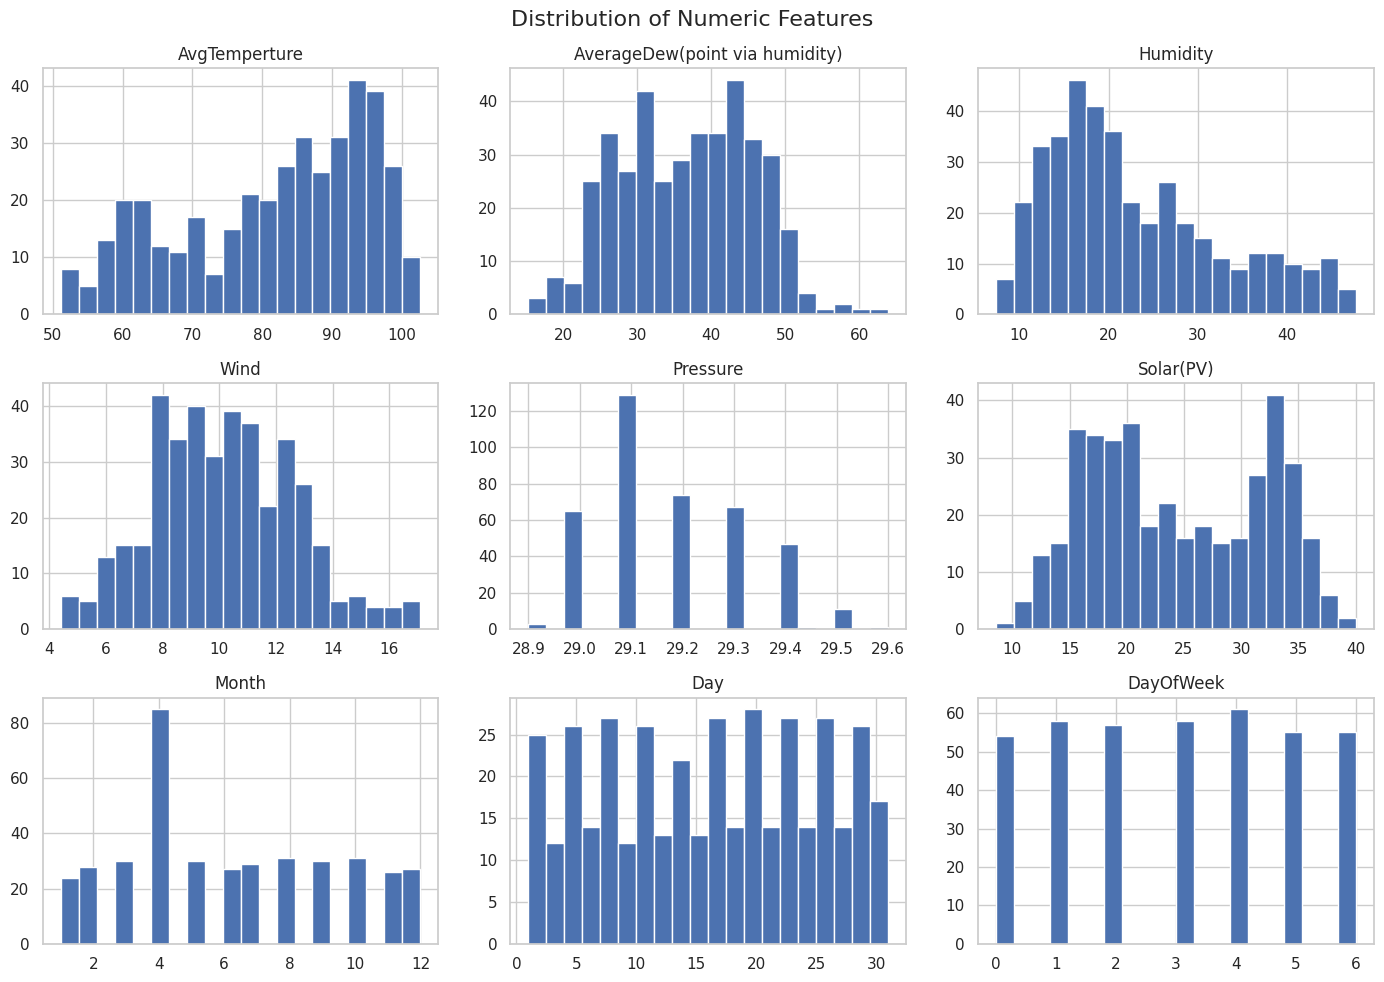

In [ ]:
# Histograms
print("\nGenerating histograms...")
plt.figure(figsize=(14, 10))
df[num_cols].hist(bins=20, figsize=(14, 10))
plt.suptitle('Distribution of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()


Generating boxplots...


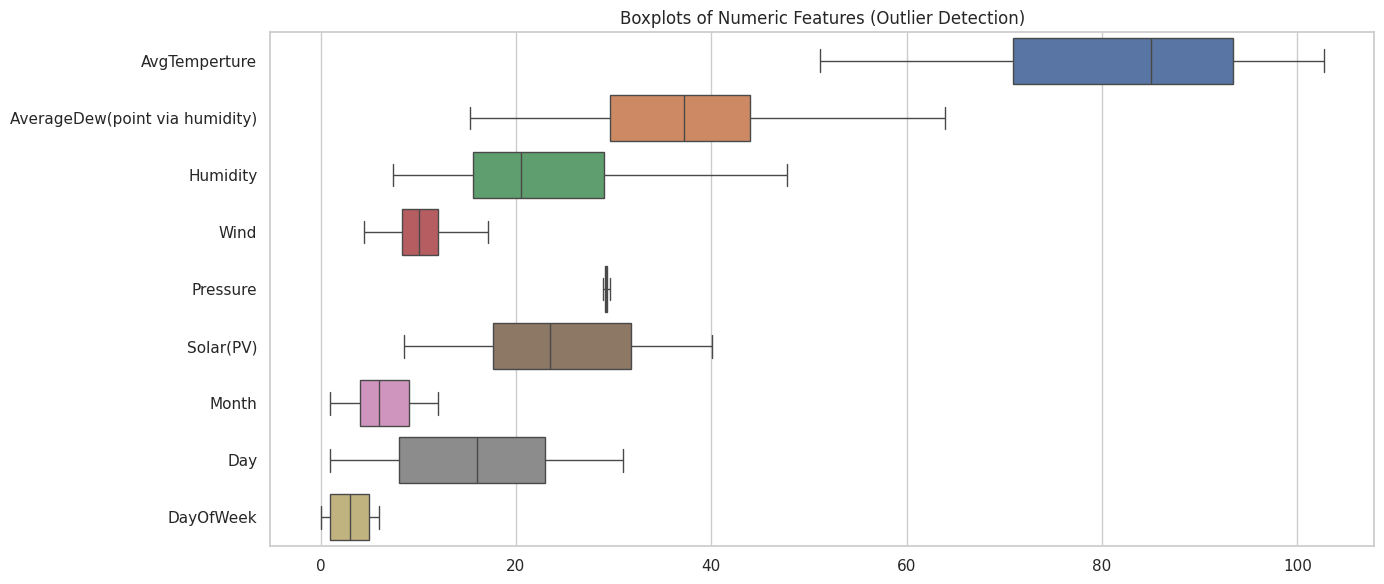

In [ ]:
# Boxplots
print("\nGenerating boxplots...")
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[num_cols], orient='h')
plt.title('Boxplots of Numeric Features (Outlier Detection)')
plt.tight_layout()
plt.show()


Generating correlation heatmap...


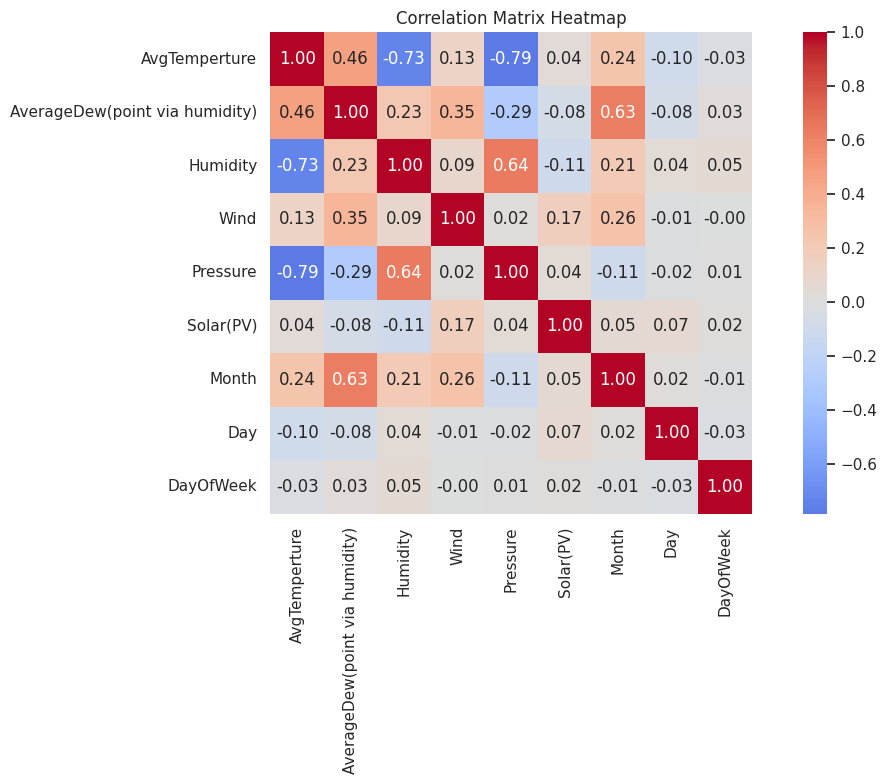

In [ ]:
# Correlation Heatmap
print("\nGenerating correlation heatmap...")
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


Generating covariance heatmap...


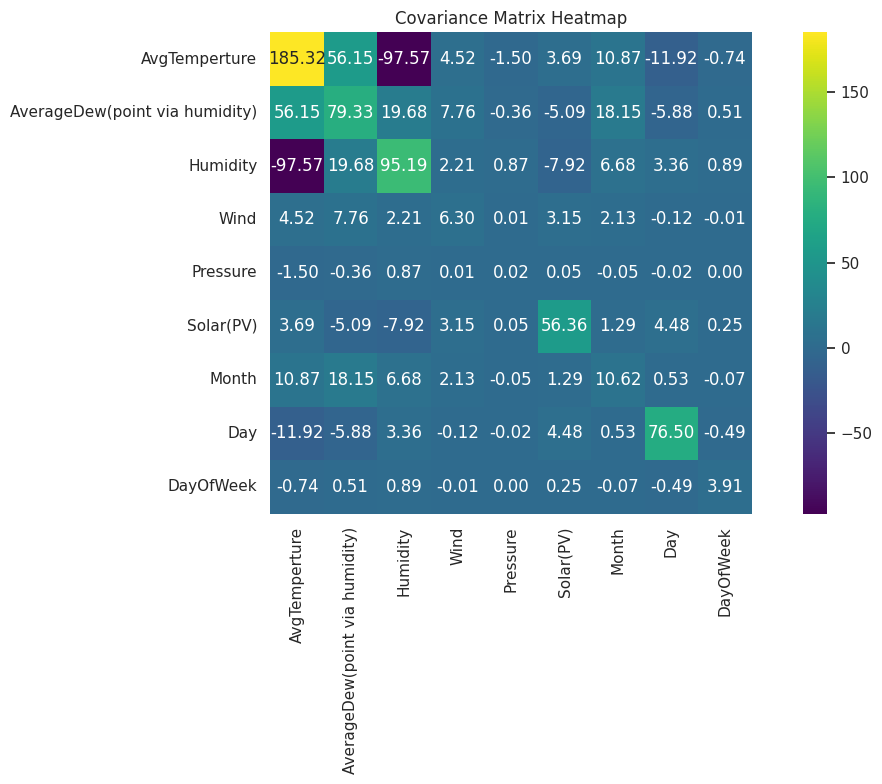

In [ ]:
# Covariance Heatmap
print("\nGenerating covariance heatmap...")
cov_matrix = df[num_cols].cov()
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, fmt='.2f', cmap='viridis', square=True)
plt.title('Covariance Matrix Heatmap')
plt.tight_layout()
plt.show()


Generating pairplot (sampled)...


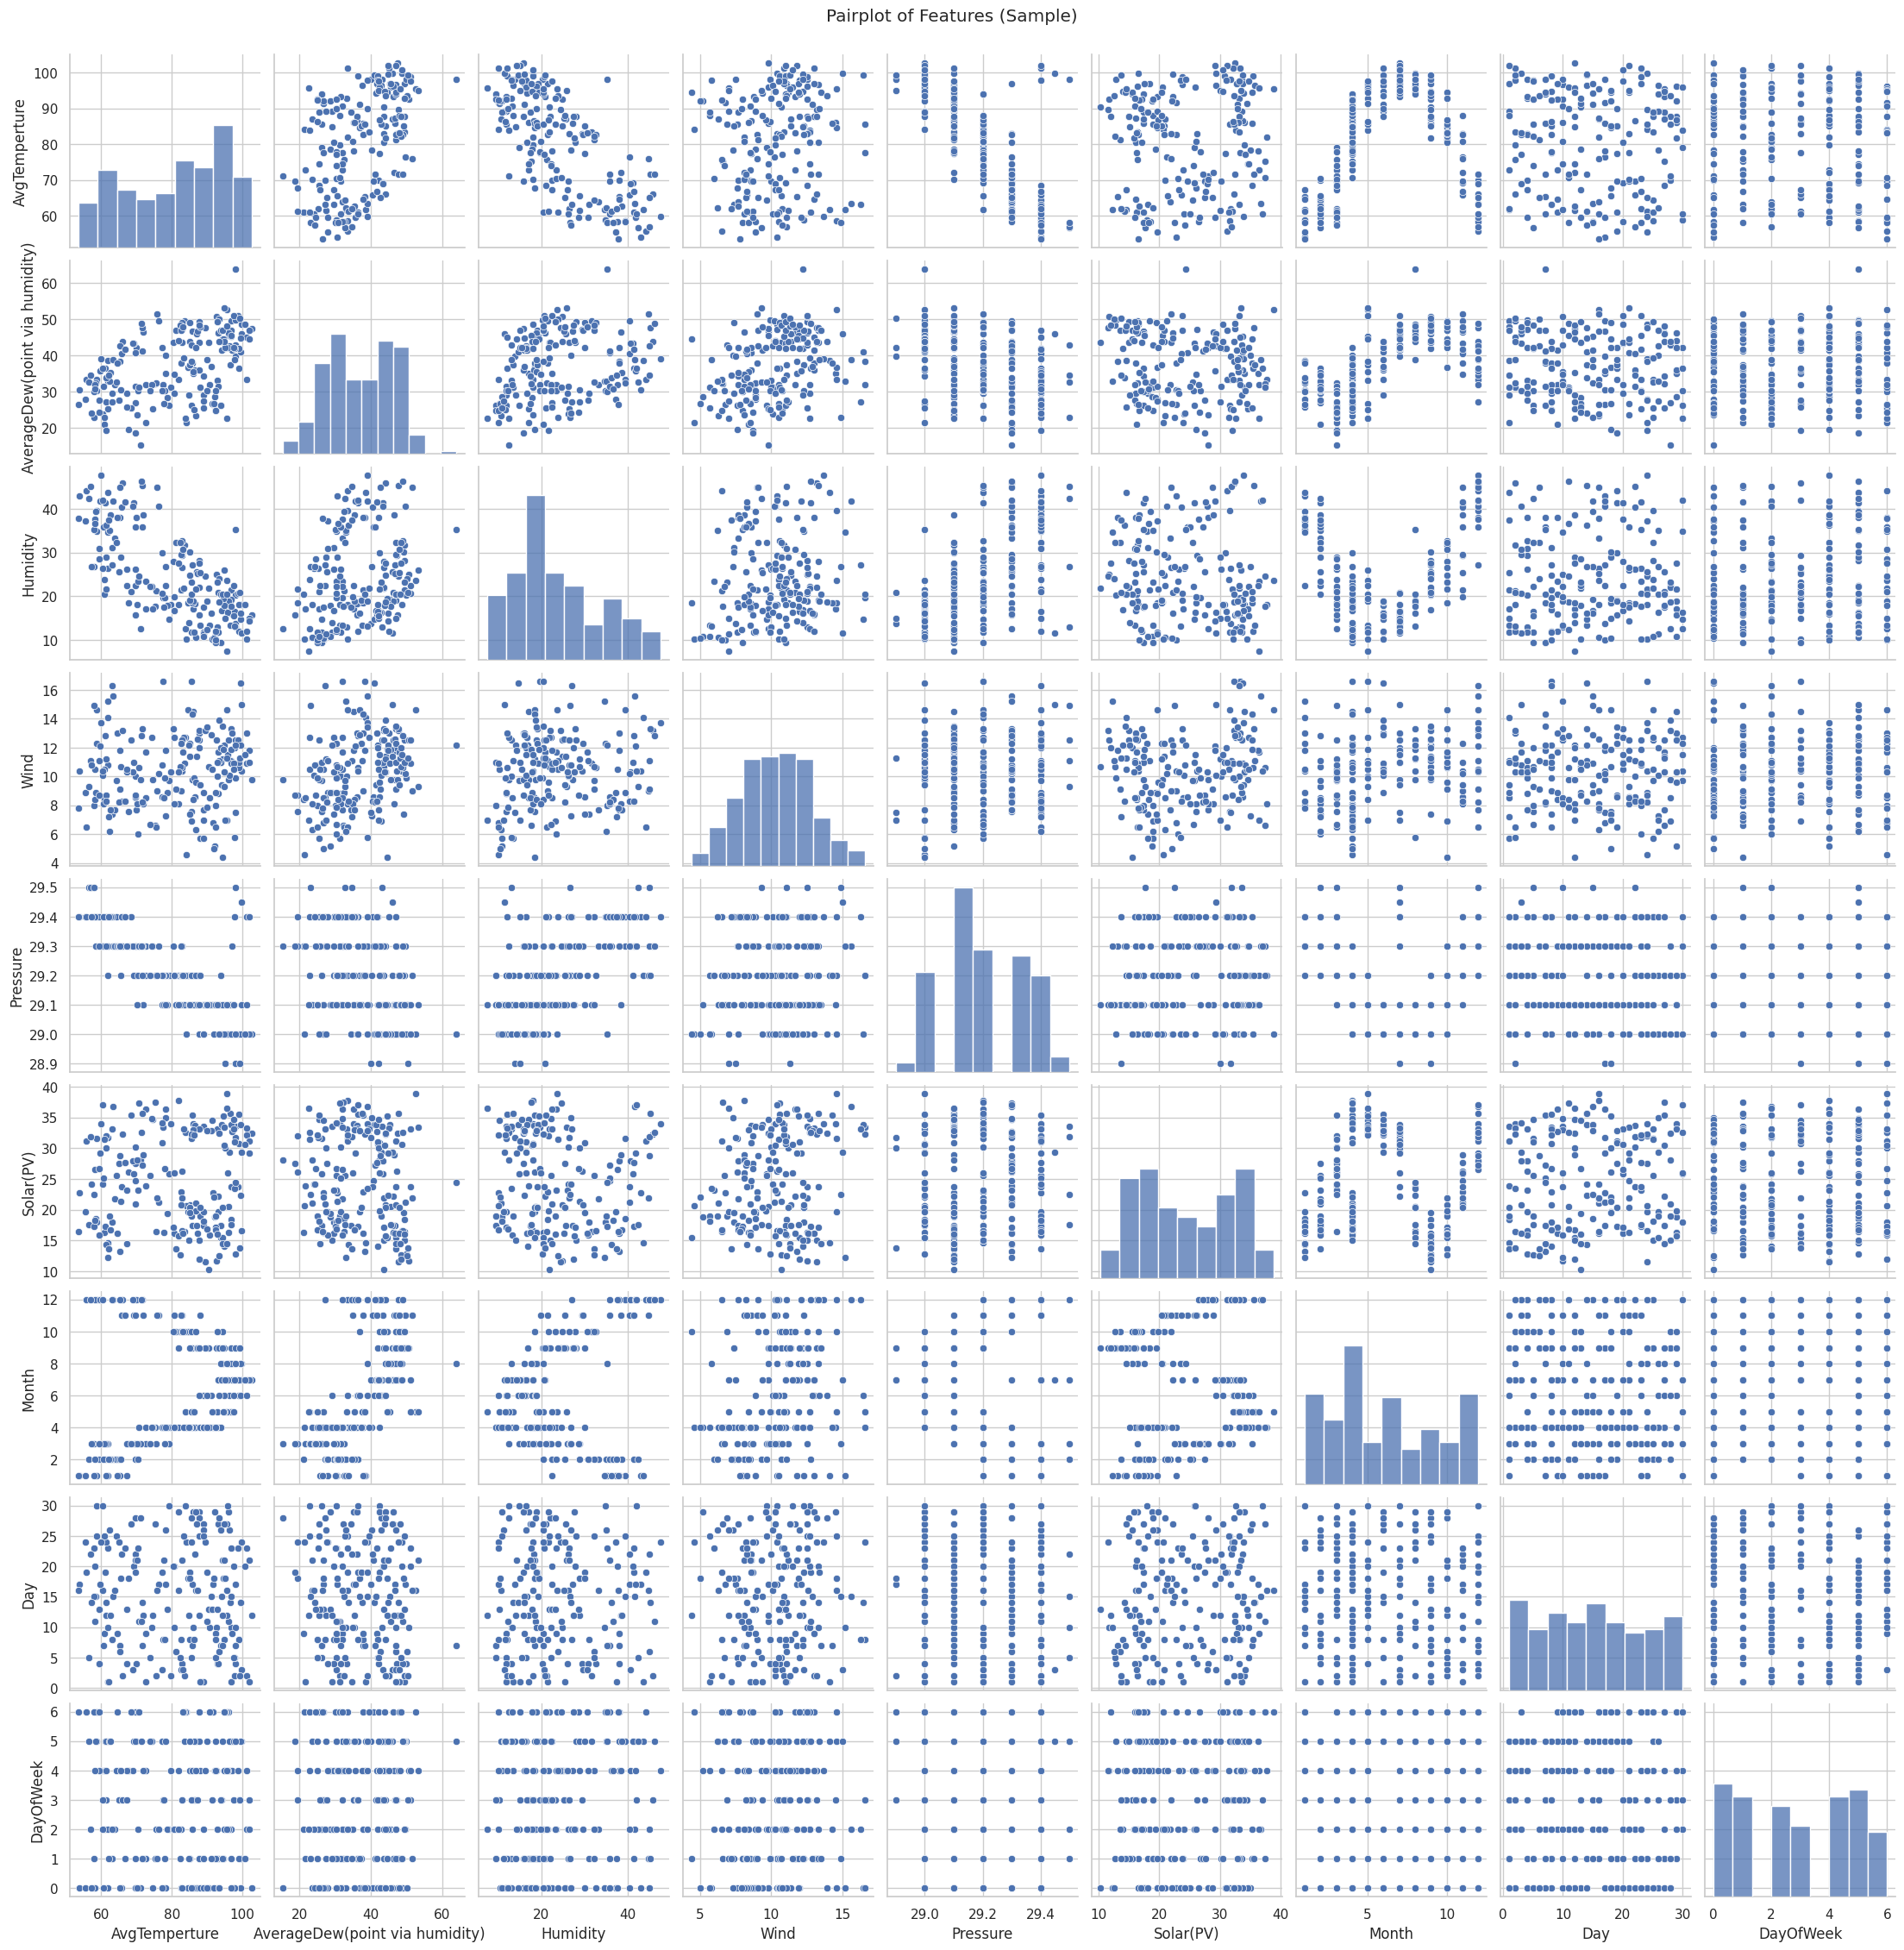

In [ ]:
# Pairplot (sampled for efficiency)
print("\nGenerating pairplot (sampled)...")
sample_size = min(200, len(df))
sample_df = df[num_cols].sample(n=sample_size, random_state=RANDOM_STATE)
sns.pairplot(sample_df)
plt.suptitle('Pairplot of Features (Sample)', y=1.01)
plt.show()

### FEATURE ENGINEERING & BINNING

In [ ]:
# Create binned temperature features
if 'AvgTemperture' in df.columns:
    df['Temp_bin_3'] = pd.qcut(df['AvgTemperture'], q=3, labels=['Low', 'Med', 'High'])
    df['Temp_bin_5'] = pd.qcut(df['AvgTemperture'], q=5, labels=False)
    print('Created temperature bins: Temp_bin_3 (Low/Med/High) and Temp_bin_5 (0-4)')

Created temperature bins: Temp_bin_3 (Low/Med/High) and Temp_bin_5 (0-4)


In [ ]:
# Create classification targets
if 'Solar(PV)' in df.columns:
    df['HighSolar'] = (df['Solar(PV)'] >= df['Solar(PV)'].median()).astype(int)
    print('Created binary target: HighSolar (based on Solar(PV) median)')

Created binary target: HighSolar (based on Solar(PV) median)


### STATISTICAL TESTS

In [ ]:
# Chi-square test (categorical vs categorical)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_cols and 'Temp_bin_3' in df.columns:
    print("--- Chi-Square Tests ---")
    for cat in cat_cols:
        if cat != 'Temp_bin_3':
            table = pd.crosstab(df[cat], df['Temp_bin_3'])
            if table.size > 0:
                chi2, p, dof, ex = chi2_contingency(table)
                print(f'{cat} vs Temp_bin_3: χ²={chi2:.3f}, p={p:.5f}, dof={dof}')

--- Chi-Square Tests ---


In [ ]:
# T-test (comparing two groups)
binary_cols = [c for c in df.columns if df[c].nunique() == 2 and pd.api.types.is_numeric_dtype(df[c])]
if binary_cols and 'AvgTemperture' in df.columns:
    print("\n--- T-Tests ---")
    b = binary_cols[0]
    group0 = df[df[b] == df[b].unique()[0]]['AvgTemperture']
    group1 = df[df[b] == df[b].unique()[1]]['AvgTemperture']
    tstat, pval = stats.ttest_ind(group0, group1, nan_policy='omit')
    print(f'AvgTemperture between groups of {b}: t={tstat:.3f}, p={pval:.5f}')


--- T-Tests ---
AvgTemperture between groups of HighSolar: t=-0.330, p=0.74164


In [ ]:
# ANOVA test
if 'Temp_bin_3' in df.columns and 'Solar(PV)' in df.columns:
    print("\n--- ANOVA Tests ---")
    groups = [df[df['Temp_bin_3'] == lvl]['Solar(PV)'] for lvl in df['Temp_bin_3'].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f'Solar(PV) across Temp_bin_3 groups: F={f_stat:.3f}, p={p_value:.5f}')
    print('Result: Statistically significant differences exist' if p_value < 0.05 else 'Result: No significant differences')


--- ANOVA Tests ---
Solar(PV) across Temp_bin_3 groups: F=1.121, p=0.32684
Result: No significant differences


### PREPARE FEATURES AND TARGET

In [ ]:
# Determine target variable
if 'HighSolar' in df.columns:
    TARGET = 'HighSolar'
elif 'Temp_bin_3' in df.columns:
    TARGET = 'Temp_bin_3'
else:
    df['Target_auto'] = pd.qcut(df[num_cols[0]], q=3, labels=False)
    TARGET = 'Target_auto'

print(f'\nUsing target variable: {TARGET}')


Using target variable: HighSolar


In [ ]:
# Prepare feature matrix
exclude_cols = [TARGET]
if TARGET == 'HighSolar' and 'Solar(PV)' in df.columns:
    exclude_cols.append('Solar(PV)')

predictors_num = [c for c in df.columns
                  if c not in exclude_cols
                  and c not in ['Temp_bin_3', 'Temp_bin_5']
                  and np.issubdtype(df[c].dtype, np.number)]

print(f'Feature columns used: {predictors_num}')

X = df[predictors_num].fillna(0).copy()

Feature columns used: ['AvgTemperture', 'AverageDew(point via humidity)', 'Humidity', 'Wind', 'Pressure', 'Month', 'Day', 'DayOfWeek']


In [ ]:
# Encode target if categorical
if df[TARGET].dtype == 'O' or df[TARGET].dtype.name == 'category':
    y = LabelEncoder().fit_transform(df[TARGET])
else:
    y = df[TARGET].values

print(f'Feature matrix shape: {X.shape}')
print(f'Target distribution: {np.bincount(y)}')

Feature matrix shape: (398, 8)
Target distribution: [199 199]


### FEATURE SELECTION

In [ ]:
# Univariate feature selection (ANOVA F-test)
if len(np.unique(y)) > 1:
    print("\n--- Univariate Feature Selection (ANOVA) ---")
    skb = SelectKBest(score_func=f_classif, k='all')
    skb.fit(X, y)
    feature_scores = pd.DataFrame({
        'feature': X.columns,
        'f_score': skb.scores_,
        'p_value': skb.pvalues_
    }).sort_values('f_score', ascending=False)
    display(feature_scores)


--- Univariate Feature Selection (ANOVA) ---


,feature,f_score,p_value
3,Wind,11.309916,0.000846
5,Month,6.372898,0.011978
4,Pressure,1.037761,0.308965
2,Humidity,1.008842,0.315794
6,Day,0.798911,0.371962
0,AvgTemperture,0.108846,0.741636
7,DayOfWeek,0.108444,0.742096
1,AverageDew(point via humidity),0.065414,0.798268



--- Tree-Based Feature Importance ---
Month                             0.567129
AvgTemperture                     0.229377
AverageDew(point via humidity)    0.065650
Humidity                          0.040405
Day                               0.038933
Wind                              0.035466
Pressure                          0.014521
DayOfWeek                         0.008520
dtype: float64


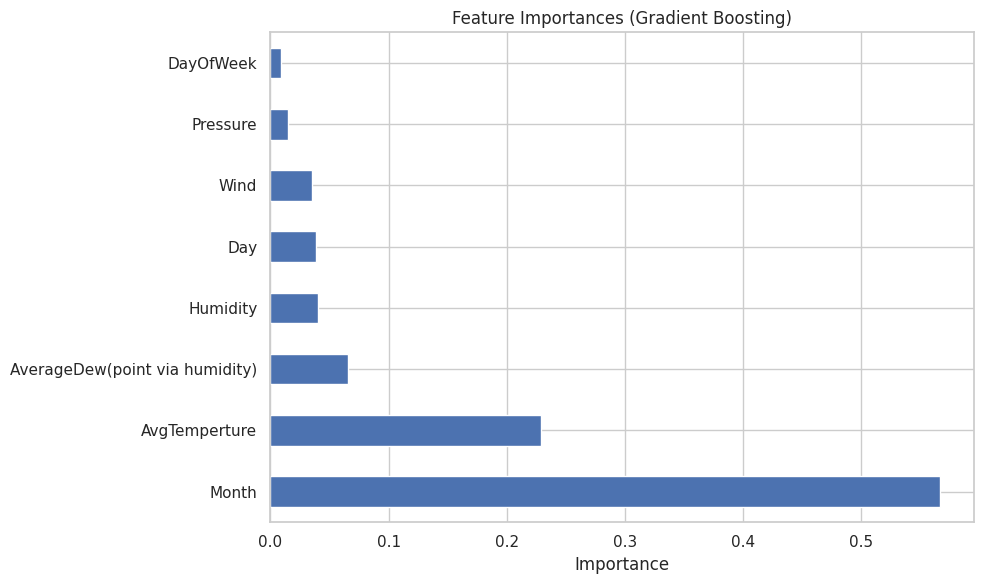

In [ ]:
# Tree-based feature importance
print("\n--- Tree-Based Feature Importance ---")
gb_fs = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_fs.fit(X, y)
importances = pd.Series(gb_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh')
plt.title('Feature Importances (Gradient Boosting)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### DIMENSIONALITY REDUCTION

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


--- Principal Component Analysis (PCA) ---
Explained variance ratio:
[0.32355578 0.24032759 0.12945552 0.12173081 0.10176862 0.05178782]
Cumulative variance explained: [0.32355578 0.56388337 0.69333889 0.8150697  0.91683833 0.96862615]


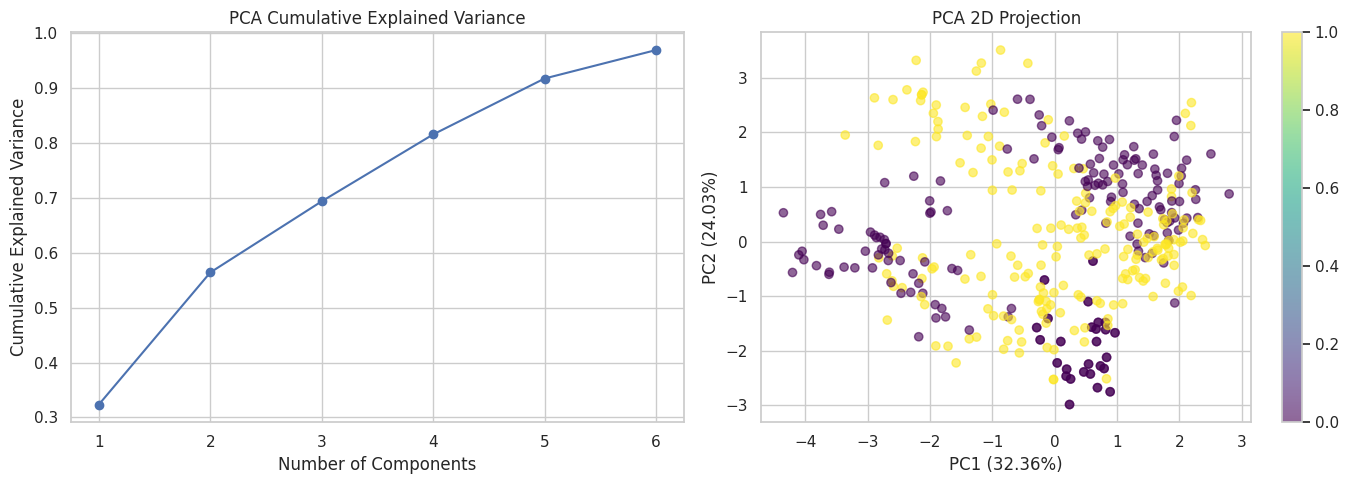

In [ ]:
# PCA
print("\n--- Principal Component Analysis (PCA) ---")
pca = PCA(n_components=min(6, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)
print('Explained variance ratio:')
print(pca.explained_variance_ratio_)
print(f'Cumulative variance explained: {pca.explained_variance_ratio_.cumsum()}')

# Plot PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative variance
axes[0].plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_), marker='o')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA Cumulative Explained Variance')
axes[0].grid(True)

# 2D projection
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title('PCA 2D Projection')
plt.colorbar(scatter, ax=axes[1])
plt.tight_layout()
plt.show()


--- Linear Discriminant Analysis (LDA) ---


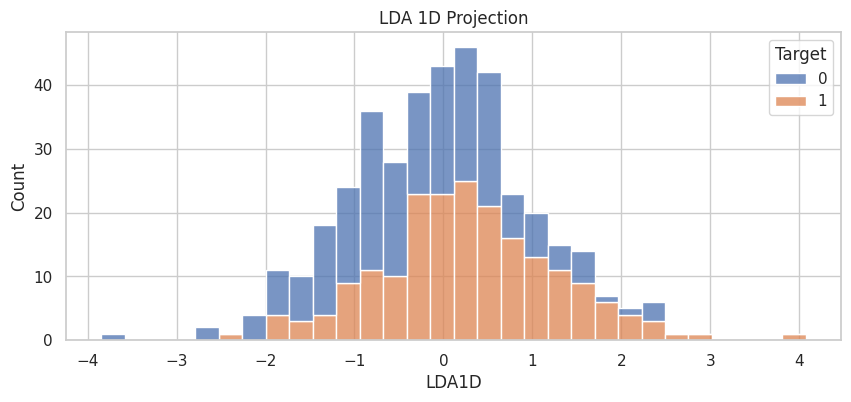

In [ ]:
# LDA
if len(np.unique(y)) > 1:
    print("\n--- Linear Discriminant Analysis (LDA) ---")
    n_components = min(len(np.unique(y)) - 1, 2)
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit_transform(X_scaled, y)

    if X_lda.ndim == 1 or X_lda.shape[1] == 1:
        plt.figure(figsize=(10, 4))
        plot_df = pd.DataFrame({'LDA1D': X_lda.flatten(), 'Target': y})
        sns.histplot(data=plot_df, x='LDA1D', hue='Target', multiple='stack', bins=30)
        plt.title('LDA 1D Projection')
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='tab10', alpha=0.6)
        plt.xlabel('LD1')
        plt.ylabel('LD2')
        plt.title('LDA 2D Projection')
        plt.colorbar(scatter)
        plt.show()


--- Singular Value Decomposition (SVD) ---
Explained variance ratio:
[0.32355578 0.24032759]


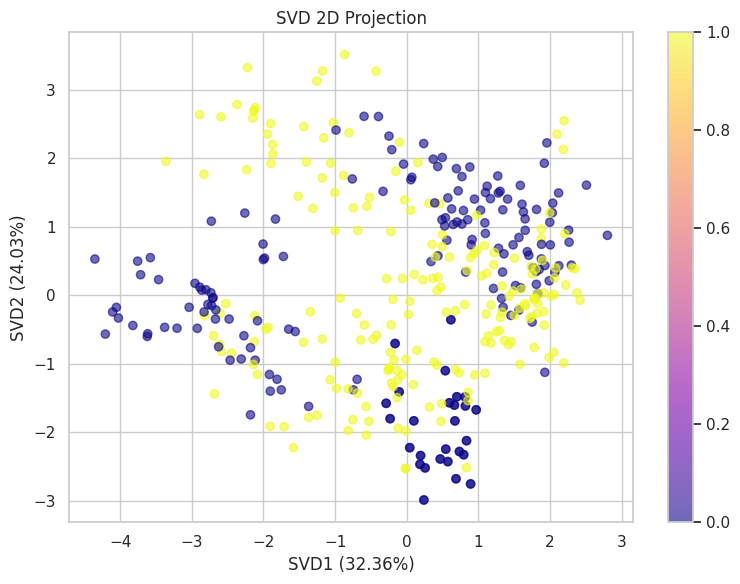

In [ ]:
# SVD
print("\n--- Singular Value Decomposition (SVD) ---")
svd = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X_scaled)
print('Explained variance ratio:')
print(svd.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y, cmap='plasma', alpha=0.6)
plt.xlabel(f'SVD1 ({svd.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'SVD2 ({svd.explained_variance_ratio_[1]:.2%})')
plt.title('SVD 2D Projection')
plt.colorbar(scatter)
plt.tight_layout()
plt.show()

### TRAIN-TEST SPLIT

In [ ]:
if len(np.unique(y)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=RANDOM_STATE
    )

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')
print(f'Training target distribution: {np.bincount(y_train)}')
print(f'Test target distribution: {np.bincount(y_test)}')

Training set: (318, 8)
Test set: (80, 8)
Training target distribution: [159 159]
Test target distribution: [40 40]


### MODEL TRAINING & EVALUATION (CLASSIFICATION)


In [ ]:
# Define models
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree (Entropy)': DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE),
    'Decision Tree (Gini)': DecisionTreeClassifier(criterion='gini', random_state=RANDOM_STATE),
    'KNN (k=5, Euclidean)': KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2),
    'KNN (k=5, Manhattan)': KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1),
    'KNN (k=5, Minkowski p=3)': KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=3),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'LDA': LinearDiscriminantAnalysis(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

In [ ]:
# Train and evaluate
results = []

for name, model in models.items():
    print(f'\n--- Training: {name} ---')

    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_pred)
    error_rate = 1 - test_acc
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # ROC-AUC for binary classification
    roc_auc = np.nan
    if hasattr(model, 'predict_proba') and len(np.unique(y)) == 2:
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    if not np.isnan(roc_auc):
        print(f'ROC-AUC: {roc_auc:.4f}')

    results.append({
        'Model': name,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'Error_Rate': error_rate,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'ROC_AUC': roc_auc,
        'Confusion_Matrix': cm
    })


--- Training: Naive Bayes ---
Train Accuracy: 0.5849
Test Accuracy: 0.5625
Precision: 0.5629
Recall: 0.5625
F1-Score: 0.5619
ROC-AUC: 0.6225

--- Training: Decision Tree (Entropy) ---
Train Accuracy: 1.0000
Test Accuracy: 0.8125
Precision: 0.8381
Recall: 0.8125
F1-Score: 0.8089
ROC-AUC: 0.8125

--- Training: Decision Tree (Gini) ---
Train Accuracy: 1.0000
Test Accuracy: 0.7875
Precision: 0.7921
Recall: 0.7875
F1-Score: 0.7867
ROC-AUC: 0.7875

--- Training: KNN (k=5, Euclidean) ---
Train Accuracy: 0.8899
Test Accuracy: 0.7750
Precision: 0.7750
Recall: 0.7750
F1-Score: 0.7750
ROC-AUC: 0.8438

--- Training: KNN (k=5, Manhattan) ---
Train Accuracy: 0.8899
Test Accuracy: 0.8375
Precision: 0.8377
Recall: 0.8375
F1-Score: 0.8375
ROC-AUC: 0.8559

--- Training: KNN (k=5, Minkowski p=3) ---
Train Accuracy: 0.8711
Test Accuracy: 0.7375
Precision: 0.7388
Recall: 0.7375
F1-Score: 0.7371
ROC-AUC: 0.8103

--- Training: Logistic Regression ---
Train Accuracy: 0.6101
Test Accuracy: 0.5750
Precision: 0

In [ ]:
# Results DataFrame
results_df = pd.DataFrame(results).sort_values('Test_Accuracy', ascending=False).reset_index(drop=True)
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
display(results_df[['Model', 'Train_Accuracy', 'Test_Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']])


MODEL COMPARISON SUMMARY


,Model,Train_Accuracy,Test_Accuracy,Precision,Recall,F1_Score,ROC_AUC
0,Gradient Boosting,0.990566,0.8750,0.878788,0.8750,0.874687,0.936250
1,Neural Network,0.877358,0.8750,0.878788,0.8750,0.874687,0.936250
2,"KNN (k=5, Manhattan)",0.889937,0.8375,0.837711,0.8375,0.837475,0.855938
3,Decision Tree (Entropy),1.000000,0.8125,0.838066,0.8125,0.808887,0.812500
4,Decision Tree (Gini),1.000000,0.7875,0.792063,0.7875,0.786667,0.787500
5,"KNN (k=5, Euclidean)",0.889937,0.7750,0.775000,0.7750,0.775000,0.843750
6,"KNN (k=5, Minkowski p=3)",0.871069,0.7375,0.738843,0.7375,0.737130,0.810312
7,LDA,0.584906,0.6125,0.618499,0.6125,0.607533,0.660000
8,Logistic Regression,0.610063,0.5750,0.576726,0.5750,0.572596,0.658750
9,Naive Bayes,0.584906,0.5625,0.562854,0.5625,0.561884,0.622500


### VISUALIZATION: CONFUSION MATRICES

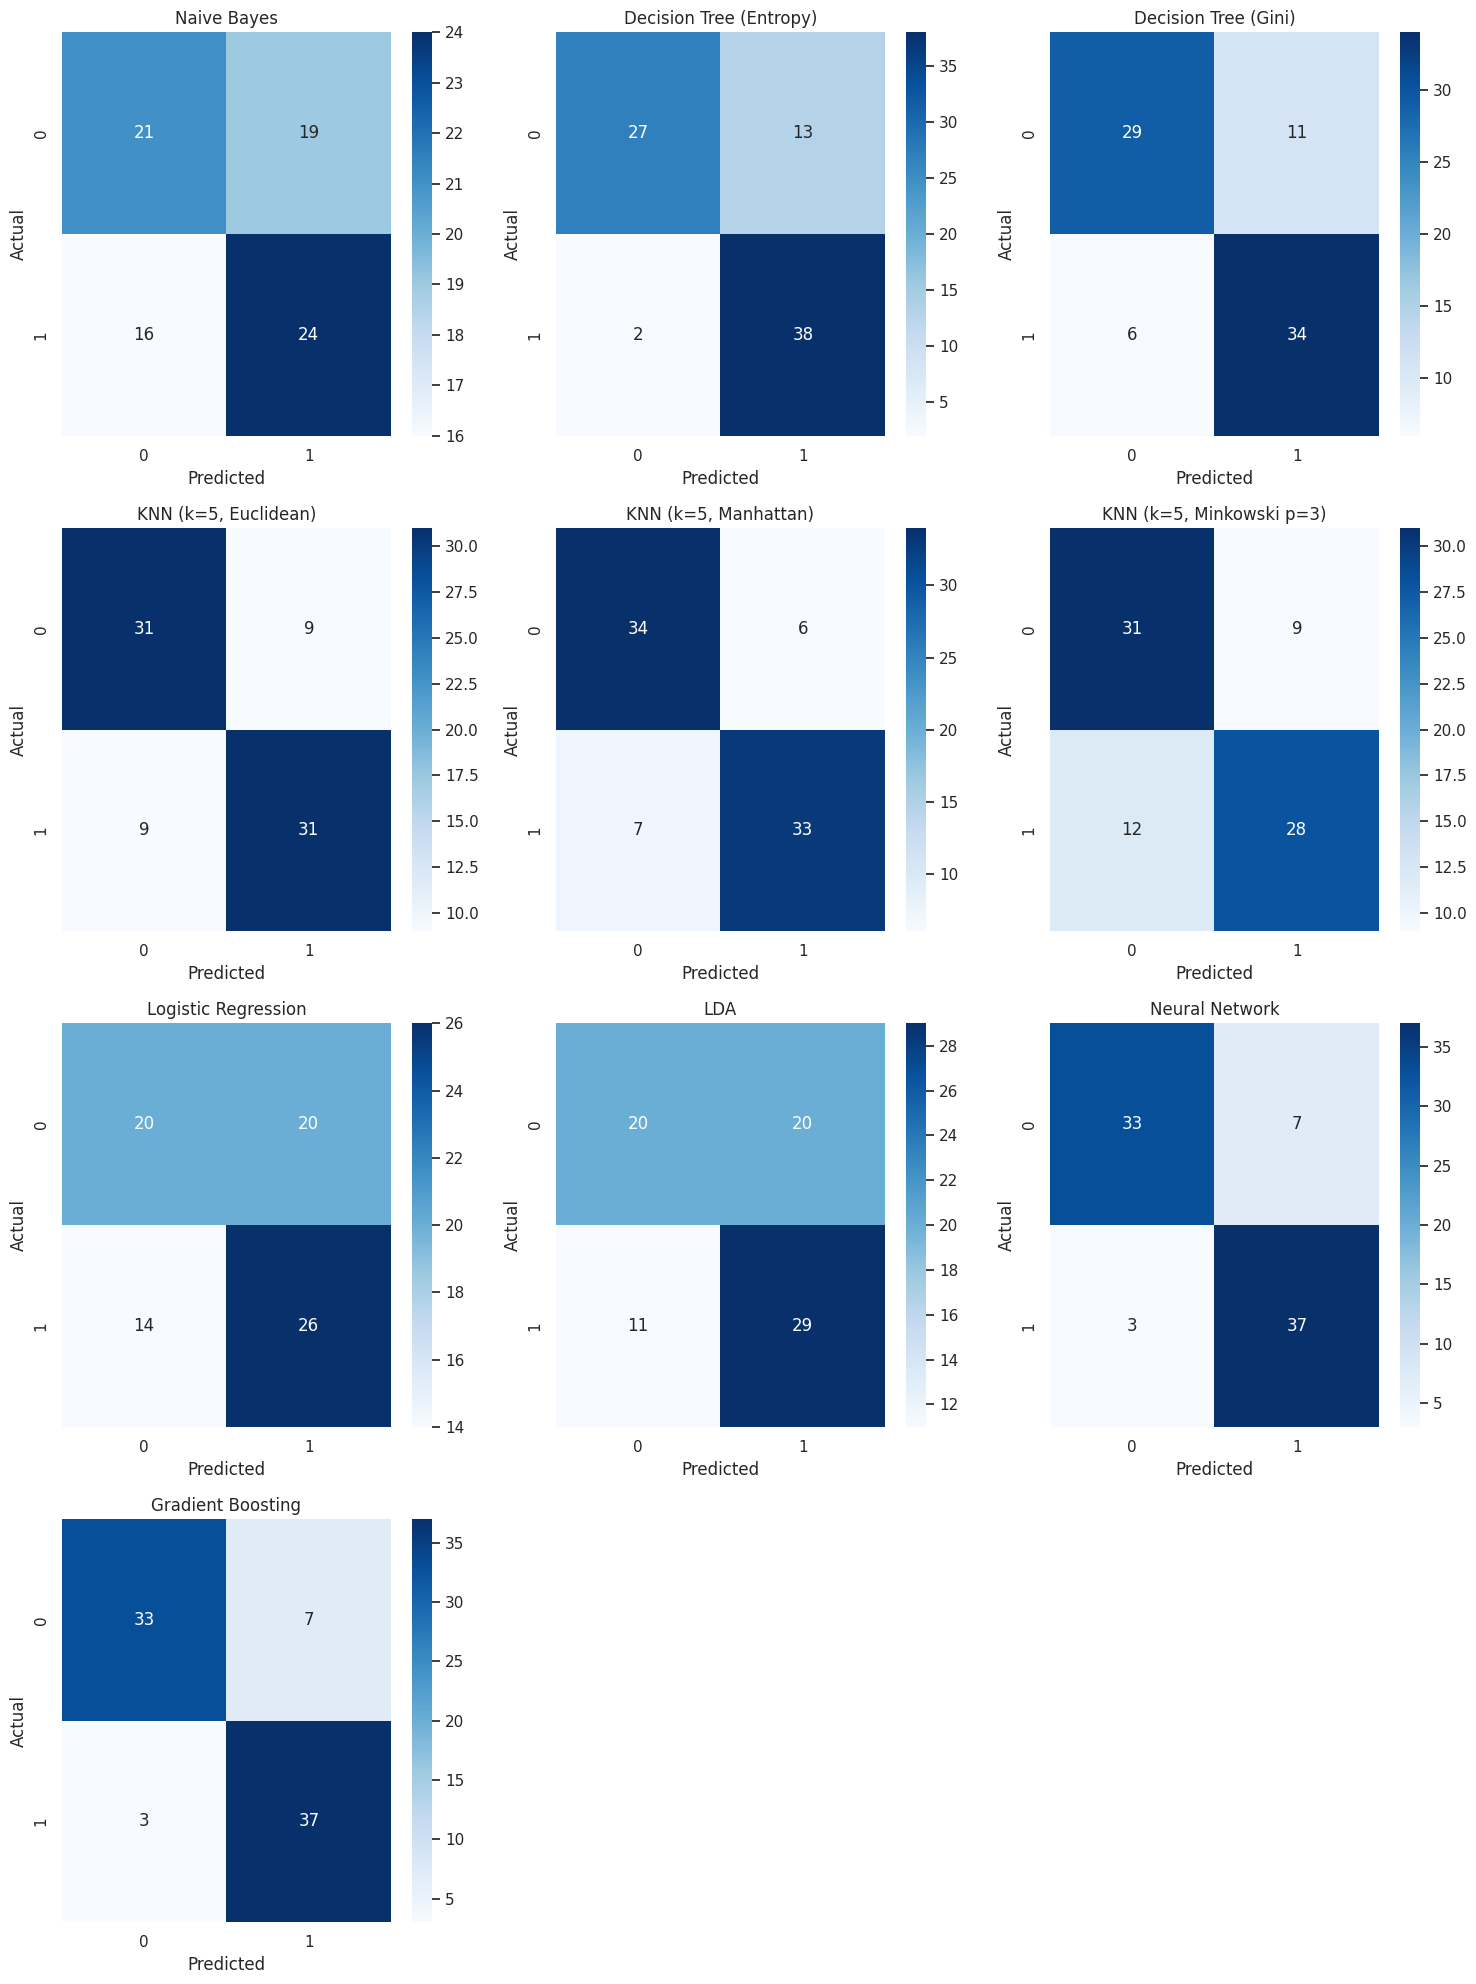

In [ ]:
n_models = len(results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, result in enumerate(results):
    sns.heatmap(result['Confusion_Matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{result['Model']}")
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### ROC CURVES (Binary Classification)



ROC CURVES


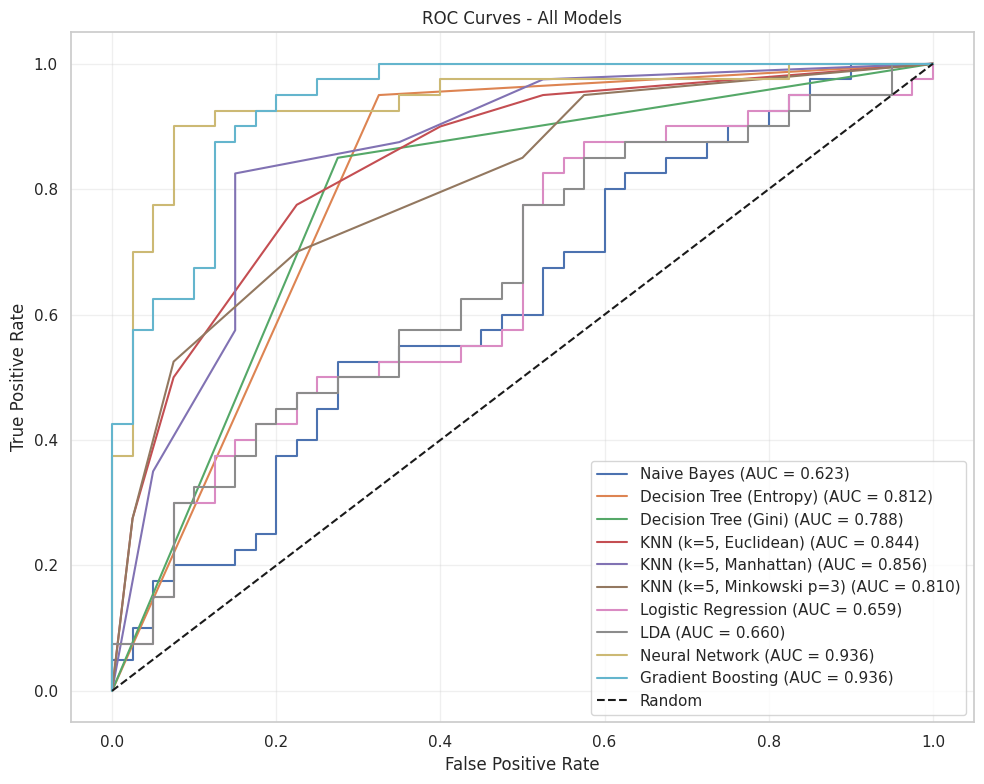

In [ ]:
if len(np.unique(y)) == 2:
    print("\n" + "="*80)
    print("ROC CURVES")
    print("="*80)

    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - All Models')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### CROSS-VALIDATION

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='accuracy')
    cv_results.append({
        'Model': name,
        'CV_Mean': scores.mean(),
        'CV_Std': scores.std(),
        'CV_Scores': scores
    })
    print(f'{name}: {scores.mean():.4f} (+/- {scores.std():.4f})')

cv_df = pd.DataFrame([{
    'Model': r['Model'],
    'CV_Mean_Accuracy': r['CV_Mean'],
    'CV_Std': r['CV_Std']
} for r in cv_results]).sort_values('CV_Mean_Accuracy', ascending=False)

display(cv_df)

Naive Bayes: 0.5626 (+/- 0.0475)
Decision Tree (Entropy): 0.8467 (+/- 0.0171)
Decision Tree (Gini): 0.8391 (+/- 0.0248)
KNN (k=5, Euclidean): 0.7966 (+/- 0.0322)
KNN (k=5, Manhattan): 0.7967 (+/- 0.0539)
KNN (k=5, Minkowski p=3): 0.7591 (+/- 0.0651)
Logistic Regression: 0.6106 (+/- 0.0194)
LDA: 0.6030 (+/- 0.0088)
Neural Network: 0.8242 (+/- 0.0300)
Gradient Boosting: 0.8896 (+/- 0.0211)


,Model,CV_Mean_Accuracy,CV_Std
9,Gradient Boosting,0.889557,0.021082
1,Decision Tree (Entropy),0.846677,0.017148
2,Decision Tree (Gini),0.839114,0.024804
8,Neural Network,0.824241,0.030007
4,"KNN (k=5, Manhattan)",0.796677,0.053889
3,"KNN (k=5, Euclidean)",0.796614,0.032248
5,"KNN (k=5, Minkowski p=3)",0.759051,0.065121
6,Logistic Regression,0.610633,0.019398
7,LDA,0.603038,0.008828
0,Naive Bayes,0.562563,0.047536


### OVERFITTING/UNDERFITTING ANALYSIS


In [ ]:
for result in results:
    train_acc = result['Train_Accuracy']
    test_acc = result['Test_Accuracy']
    gap = train_acc - test_acc

    status = 'Good Fit'
    if gap > 0.10:
        status = '⚠️ OVERFITTING'
    elif gap < -0.05:
        status = '⚠️ UNDERFITTING'

    print(f"{result['Model']:30s} | Train: {train_acc:.3f} | Test: {test_acc:.3f} | Gap: {gap:+.3f} | {status}")

Naive Bayes                    | Train: 0.585 | Test: 0.562 | Gap: +0.022 | Good Fit
Decision Tree (Entropy)        | Train: 1.000 | Test: 0.812 | Gap: +0.188 | ⚠️ OVERFITTING
Decision Tree (Gini)           | Train: 1.000 | Test: 0.787 | Gap: +0.213 | ⚠️ OVERFITTING
KNN (k=5, Euclidean)           | Train: 0.890 | Test: 0.775 | Gap: +0.115 | ⚠️ OVERFITTING
KNN (k=5, Manhattan)           | Train: 0.890 | Test: 0.838 | Gap: +0.052 | Good Fit
KNN (k=5, Minkowski p=3)       | Train: 0.871 | Test: 0.738 | Gap: +0.134 | ⚠️ OVERFITTING
Logistic Regression            | Train: 0.610 | Test: 0.575 | Gap: +0.035 | Good Fit
LDA                            | Train: 0.585 | Test: 0.613 | Gap: -0.028 | Good Fit
Neural Network                 | Train: 0.877 | Test: 0.875 | Gap: +0.002 | Good Fit
Gradient Boosting              | Train: 0.991 | Test: 0.875 | Gap: +0.116 | ⚠️ OVERFITTING


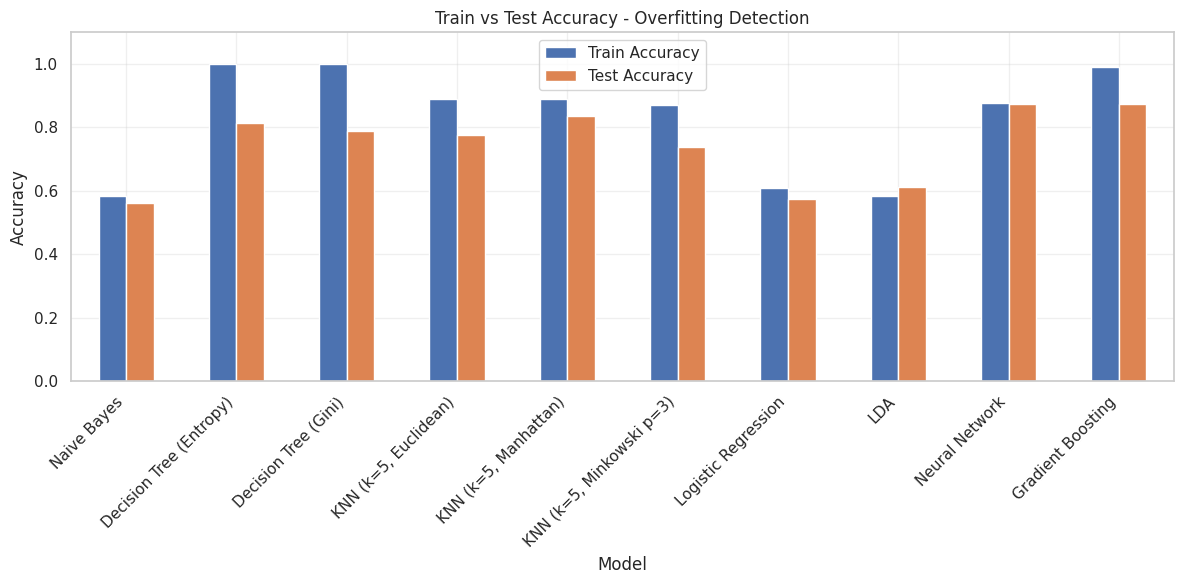

In [ ]:
# Visualization
train_test_df = pd.DataFrame([{
    'Model': r['Model'],
    'Train': r['Train_Accuracy'],
    'Test': r['Test_Accuracy']
} for r in results]).set_index('Model')

train_test_df.plot(kind='bar', figsize=(12, 6))
plt.title('Train vs Test Accuracy - Overfitting Detection')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### LEARNING CURVES

Generating learning curve for best model: Gradient Boosting


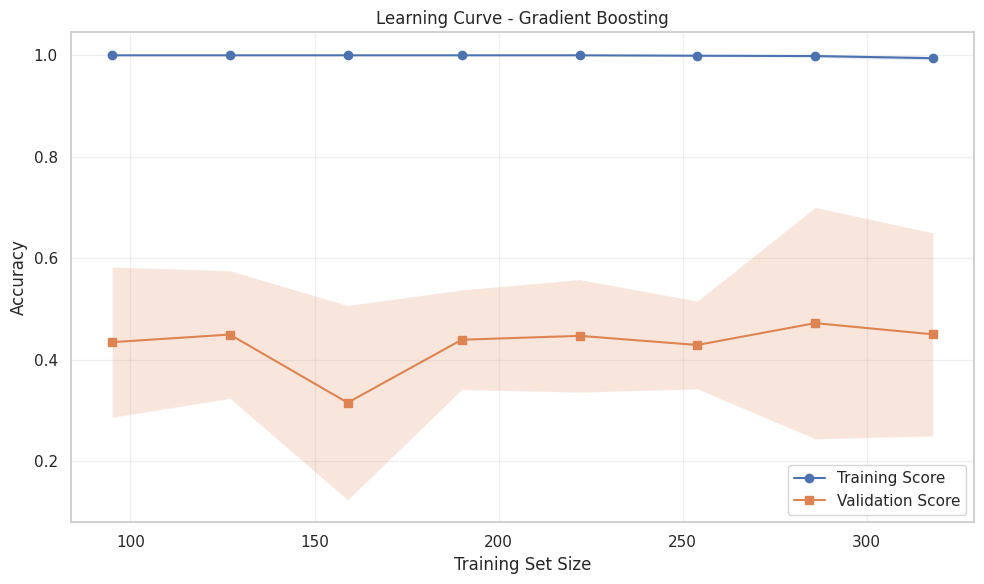

In [ ]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f'Generating learning curve for best model: {best_model_name}')

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_scaled, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Score', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title(f'Learning Curve - {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### REGRESSION ANALYSIS (if applicable)


REGRESSION ANALYSIS
Linear Regression Results:
MAE: 6.1119
RMSE: 7.2271
R² Score: 0.0470


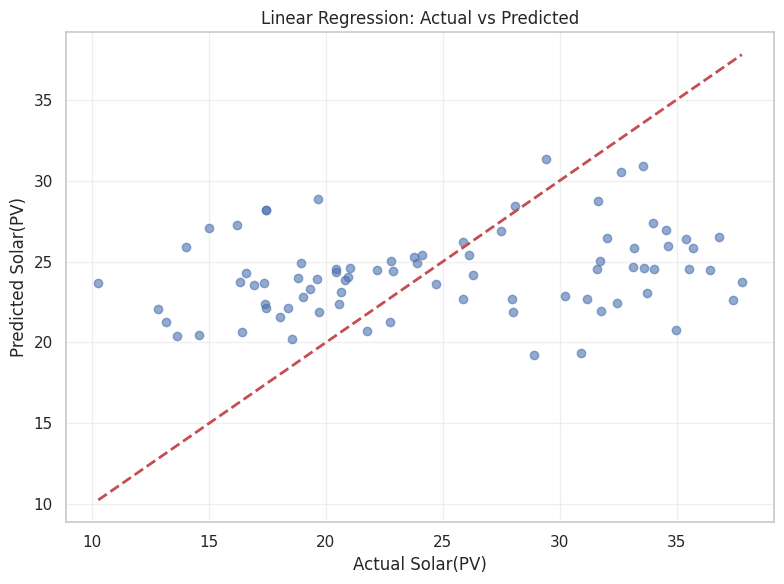

In [ ]:
if 'Solar(PV)' in df.columns:
    print("\n" + "="*80)
    print("REGRESSION ANALYSIS")
    print("="*80)

    y_reg = df['Solar(PV)'].values
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_scaled, y_reg, test_size=0.2, random_state=RANDOM_STATE
    )

    lr = LinearRegression()
    lr.fit(X_train_r, y_train_r)
    y_pred_r = lr.predict(X_test_r)

    mae = mean_absolute_error(y_test_r, y_pred_r)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
    r2 = r2_score(y_test_r, y_pred_r)

    print(f'Linear Regression Results:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R² Score: {r2:.4f}')

    # Prediction vs Actual plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_r, y_pred_r, alpha=0.6)
    plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
    plt.xlabel('Actual Solar(PV)')
    plt.ylabel('Predicted Solar(PV)')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### BEST MODEL INTERPRETATION

In [ ]:
best_result = results_df.iloc[0]
print(f"\nBest performing model: {best_result['Model']}")
print(f"Test Accuracy: {best_result['Test_Accuracy']:.4f}")

cm = next(r['Confusion_Matrix'] for r in results if r['Model'] == best_result['Model'])
print(f"\nConfusion Matrix:")
print(cm)

if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\nSensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print("\nInterpretation:")
    print("• High sensitivity indicates the model successfully detects positive cases")
    print("• High specificity indicates the model correctly identifies negative cases")

    if best_result['Train_Accuracy'] - best_result['Test_Accuracy'] > 0.05:
        print("⚠️ Warning: Model shows signs of overfitting (train >> test)")
    else:
        print("✓ Model shows good generalization")
else:
    print("\nMulticlass confusion matrix - use per-class precision/recall from classification report")
    print("\nClassification Report:")
    best_model = models[best_result['Model']]
    y_pred_best = best_model.predict(X_test)
    print(classification_report(y_test, y_pred_best))


Best performing model: Gradient Boosting
Test Accuracy: 0.8750

Confusion Matrix:
[[33  7]
 [ 3 37]]

Sensitivity (Recall): 0.925
Specificity: 0.825

Interpretation:
• High sensitivity indicates the model successfully detects positive cases
• High specificity indicates the model correctly identifies negative cases
⚠️ Warning: Model shows signs of overfitting (train >> test)


### DECISION TREE ERROR ESTIMATION

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

# Resubstitution error (training error)
train_pred = dt.predict(X_train)
train_acc_dt = accuracy_score(y_train, train_pred)
resub_error = 1 - train_acc_dt

# Test error
test_pred = dt.predict(X_test)
test_acc_dt = accuracy_score(y_test, test_pred)
test_error = 1 - test_acc_dt

# Cross-validated error
cv_preds = cross_val_predict(dt, X_scaled, y, cv=skf)
cv_acc_dt = accuracy_score(y, cv_preds)
cv_error = 1 - cv_acc_dt

print(f'Resubstitution Error (Training): {resub_error:.4f} (Accuracy: {train_acc_dt:.4f})')
print(f'Test Error: {test_error:.4f} (Accuracy: {test_acc_dt:.4f})')
print(f'Cross-Validation Error: {cv_error:.4f} (Accuracy: {cv_acc_dt:.4f})')

print("\nError Estimation Methods:")
print("• Resubstitution: Optimistically biased (underestimates true error)")
print("• Test Set: Unbiased estimate of generalization error")
print("• Cross-Validation: More robust estimate, uses all data")

Resubstitution Error (Training): 0.0000 (Accuracy: 1.0000)
Test Error: 0.1875 (Accuracy: 0.8125)
Cross-Validation Error: 0.1533 (Accuracy: 0.8467)

Error Estimation Methods:
• Resubstitution: Optimistically biased (underestimates true error)
• Test Set: Unbiased estimate of generalization error
• Cross-Validation: More robust estimate, uses all data


### FINAL SUMMARY

In [ ]:
print("\n📊 Dataset Summary:")
print(f"   • Total samples: {len(df)}")
print(f"   • Features: {len(predictors_num)}")
print(f"   • Target classes: {len(np.unique(y))}")
print(f"   • Train/Test split: 80/20")

print("\n🏆 Best Model Performance:")
print(f"   • Model: {results_df.iloc[0]['Model']}")
print(f"   • Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.4f}")
print(f"   • F1-Score: {results_df.iloc[0]['F1_Score']:.4f}")
print(f"   • Cross-Val Accuracy: {cv_df.iloc[0]['CV_Mean_Accuracy']:.4f}")

print("\n🔝 Top 3 Models:")
for i in range(min(3, len(results_df))):
    print(f"   {i+1}. {results_df.iloc[i]['Model']}: {results_df.iloc[i]['Test_Accuracy']:.4f}")

print("\n📈 Key Findings:")
print(f"   • PCA: First 2 components explain {pca.explained_variance_ratio_[:2].sum():.2%} of variance")
print(f"   • Most important features: {', '.join(importances.head(3).index.tolist())}")
if len(np.unique(y)) == 2:
    avg_roc = results_df['ROC_AUC'].mean()
    print(f"   • Average ROC-AUC across models: {avg_roc:.4f}")

print("\n💡 Recommendations:")
overfitting_models = [r['Model'] for r in results if r['Train_Accuracy'] - r['Test_Accuracy'] > 0.10]
if overfitting_models:
    print(f"   • Address overfitting in: {', '.join(overfitting_models[:3])}")
    print("   • Consider: regularization, feature selection, or ensemble methods")
else:
    print("   • Models show good generalization")
    print("   • Consider ensemble methods to further improve performance")

print("\n✅ Analysis Complete!")


📊 Dataset Summary:
   • Total samples: 398
   • Features: 8
   • Target classes: 2
   • Train/Test split: 80/20

🏆 Best Model Performance:
   • Model: Gradient Boosting
   • Test Accuracy: 0.8750
   • F1-Score: 0.8747
   • Cross-Val Accuracy: 0.8896

🔝 Top 3 Models:
   1. Gradient Boosting: 0.8750
   2. Neural Network: 0.8750
   3. KNN (k=5, Manhattan): 0.8375

📈 Key Findings:
   • PCA: First 2 components explain 56.39% of variance
   • Most important features: Month, AvgTemperture, AverageDew(point via humidity)
   • Average ROC-AUC across models: 0.7924

💡 Recommendations:
   • Address overfitting in: Decision Tree (Entropy), Decision Tree (Gini), KNN (k=5, Euclidean)
   • Consider: regularization, feature selection, or ensemble methods

✅ Analysis Complete!


### SAVE RESULTS

In [ ]:
# Save model comparison results
output_path = '/content/sample_data/aswan_comprehensive_results.csv'
results_df.to_csv(output_path, index=False)
print(f"✓ Model results saved to: {output_path}")

# Save cross-validation results
cv_output_path = '/content/sample_data/aswan_cv_results.csv'
cv_df.to_csv(cv_output_path, index=False)
print(f"✓ Cross-validation results saved to: {cv_output_path}")

# Save feature importance
importance_path = '/content/sample_data/aswan_feature_importance.csv'
importances.to_csv(importance_path, header=['importance'])
print(f"✓ Feature importance saved to: {importance_path}")

✓ Model results saved to: /content/sample_data/aswan_comprehensive_results.csv
✓ Cross-validation results saved to: /content/sample_data/aswan_cv_results.csv
✓ Feature importance saved to: /content/sample_data/aswan_feature_importance.csv


In [ ]:
print("REFERENCES")

references = [
    "1- Tiberiu Tudorache, Liviu Kreindler “Design of a Solar Tracker System for PV Power Plants,” Acta Polytechnica Hungarica, vol. 7, no. 1, pp. 23 39, 2010.",

    "2- M. Abuella and B. Chowdhury, “Solar Power Probabilistic Forecasting by Using Multiple Linear Regression Analysis,” in IEEE Southeast conference Proceedings, Ft.Lauderdale, FL, 2015.",

    "3- J. Zeng and W. Qiao, \"Short-term solar power prediction using an RBF neural network,\" 2011 IEEE Power and Energy Society General Meeting, Detroit, MI, USA, 2011, pp. 1-8, doi: 10.1109/PES.2011.6039204",

    "4-	Kosmopoulos, P.G.; Kazadzis, S.; El-Askary, H.; Taylor, M.; Gkikas, A.; Proestakis, E.; Kontoes, C.; El-Khayat, M.M. Earth-Observation-Based Estimation and Forecasting of Particulate Matter Impact on Solar Energy in Egypt. Remote Sens. 2018, 10, 1870. https://doi.org/10.3390/rs10121870",

    "5- Aswan Weather Dataset - Source: /content/sample_data/AswanData_weatherdata.csv"
]

for ref in references:
    print(ref)

REFERENCES
1- Tiberiu Tudorache, Liviu Kreindler “Design of a Solar Tracker System for PV Power Plants,” Acta Polytechnica Hungarica, vol. 7, no. 1, pp. 23 39, 2010.
2- M. Abuella and B. Chowdhury, “Solar Power Probabilistic Forecasting by Using Multiple Linear Regression Analysis,” in IEEE Southeast conference Proceedings, Ft.Lauderdale, FL, 2015.
3- J. Zeng and W. Qiao, "Short-term solar power prediction using an RBF neural network," 2011 IEEE Power and Energy Society General Meeting, Detroit, MI, USA, 2011, pp. 1-8, doi: 10.1109/PES.2011.6039204
4-	Kosmopoulos, P.G.; Kazadzis, S.; El-Askary, H.; Taylor, M.; Gkikas, A.; Proestakis, E.; Kontoes, C.; El-Khayat, M.M. Earth-Observation-Based Estimation and Forecasting of Particulate Matter Impact on Solar Energy in Egypt. Remote Sens. 2018, 10, 1870. https://doi.org/10.3390/rs10121870
5- Aswan Weather Dataset - Source: /content/sample_data/AswanData_weatherdata.csv
